In [99]:
# %pip install numpy pandas pillow scikit-learn kagglehub matplotlib ipython
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# !conda install -c conda-forge background-generator -y


In [100]:
import os
import pandas as pd
import numpy as np
import math
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader, Subset, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display

In [101]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA version:", torch.version.cuda)
    print("Device name:", device)
else:
    device = torch.device("cpu")
    print("CUDA is not available")
    print("Device name:", device)


CUDA is not available
Device name: cpu


In [102]:
class Display:
    @staticmethod
    def image_Display(image):
        if torch.is_tensor(image):
            image = image.detach().cpu().numpy()

        if image.ndim == 1:
            image = image.reshape(28,28)

        image = image.astype('uint8')  # ensure proper display format

        display(Image.fromarray(image, mode='L'))


In [103]:
# def convert_merged_csv_to_pt(train_csv_path, test_csv_path, pt_path):
#     dtype_map = {'label': 'int64'} | {str(i): 'uint8' for i in range(1, 785)}
#
#     df_train = pd.read_csv(train_csv_path, dtype=dtype_map, low_memory=False)
#     df_test = pd.read_csv(test_csv_path, dtype=dtype_map, low_memory=False)
#
#     df = pd.concat([df_train, df_test], ignore_index=True).sample(frac=1, random_state=42)
#
#     pixel_array = df.drop(columns='label').to_numpy(dtype='float32', copy=True)
#     label_array = df['label'].to_numpy(dtype='int64', copy=True)
#
#     pixels = torch.from_numpy(pixel_array)
#     labels = torch.from_numpy(label_array)
#
#     torch.save((pixels, labels), pt_path)
#     print(f"✅ Saved: {pt_path}")
#
# convert_merged_csv_to_pt("Dataset/mnist_train.csv", "Dataset/mnist_test.csv", "Dataset/mnist.pt")

In [104]:
class Dataset(Dataset):
    def __init__(self, pt_path):
        self.pixels, self.labels = torch.load(pt_path, weights_only=True)

    def __getitem__(self, index):
        return self.pixels[index], self.labels[index]

    def __len__(self):
        return self.labels.size(0)

In [105]:
# def benchmark_workers(pt_path="Dataset/mnist.pt", max_workers=12, batch_size=512):
#     dataset = Dataset(pt_path)
#     indices = np.arange(len(dataset))
#     train_idx, _ = train_test_split(indices, test_size=0.2, shuffle=True)
#     train_set = Subset(dataset, train_idx)
#
#
#     for nw in range(max_workers + 1):
#         loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,
#                                              num_workers=nw, pin_memory=True,
#                                              persistent_workers=(nw > 0))
#         torch.cuda.synchronize() if torch.cuda.is_available() else None
#         t0 = time.perf_counter()
#
#         for x, y in loader:
#             pass  # simulate one epoch
#
#         torch.cuda.synchronize() if torch.cuda.is_available() else None
#         t1 = time.perf_counter()
#         print(f"num_workers={nw:<2} | time: {t1 - t0:.3f} sec")
#
# benchmark_workers()

In [106]:
class Dataloaders:
    def __init__(self, dataset_cls):
        self.dataset_cls = dataset_cls

    def get(self, pt_path, batch_size=None, test_size=0.09, num_workers=0):
        dataset = self.dataset_cls(pt_path)

        indices = np.arange(len(dataset))
        train_idx, test_idx = train_test_split(indices, test_size=test_size, shuffle=True)

        train_set = Subset(dataset, train_idx)
        test_set = Subset(dataset, test_idx)

        effective_batch_size = len(train_set) if batch_size is None else batch_size

        train_loader = DataLoader(train_set, batch_size=effective_batch_size, shuffle=True,
                                  num_workers=num_workers, pin_memory=True,
                                  persistent_workers=(num_workers > 0))

        test_loader = DataLoader(test_set, batch_size=len(test_set) if batch_size is None else batch_size,
                                 shuffle=False, num_workers=num_workers, pin_memory=True,
                                 persistent_workers=(num_workers > 0))

        return train_loader, test_loader


In [107]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [108]:
loaders = Dataloaders(Dataset)

train_loader, test_loader = loaders.get("/content/drive/MyDrive/Dataset/mnist.pt", batch_size=None)

for x, y in train_loader:
    x = x.to(device, non_blocking=True)
    y = y.to(device, non_blocking=True)


    print(x.shape, y.shape)
    break


torch.Size([63700, 784]) torch.Size([63700])


In [109]:
class Scaling(nn.Module):
    def __init__(self, input_tensor: torch.Tensor, bounds=(0.0, 255.0)):
        super().__init__()

        self.device = input_tensor.device
        self.input_dtype = input_tensor.dtype

        min_val = input_tensor.min()
        max_val = input_tensor.max()

        lower, upper = map(float, bounds)
        delta_mm = max_val - min_val
        delta_ul = upper - lower

        a = delta_mm + delta_ul
        b = lower * delta_mm + min_val * delta_ul
        c = 2 * delta_mm * delta_ul

        self.register_buffer("a", a)
        self.register_buffer("b", b)
        self.register_buffer("c", c)

    def forward(self, input_tensor: torch.Tensor):
        if self.c == 0: return input_tensor
        return (self.a * input_tensor - self.b) / self.c

    @torch.no_grad()
    def inverse(self, scaled_tensor: torch.Tensor):
        if self.c == 0: return scaled_tensor
        return (self.c * scaled_tensor + self.b) / self.a


In [110]:
class Classifier(nn.Module):
    def __init__(self, categories: int):
        super().__init__()
        self.categories = categories

    def forward(self, labels: torch.Tensor) -> torch.Tensor:
        return F.one_hot(labels.view(-1), num_classes=self.categories).float()

    @torch.no_grad()
    def inverse(self, one_hot_tensor: torch.Tensor) -> torch.Tensor:
        return one_hot_tensor.argmax(dim=1, keepdim=True)


In [111]:
for x, y in train_loader:
    x = x.to(device, non_blocking=True)
    y = y.to(device, non_blocking=True)


    bounds = (0.0, 255.0)
    Scaling1 = Scaling(x, bounds)
    Classifier1 = Classifier(10).to(device, non_blocking=True)


    print(x.shape, y.shape)
    break

torch.Size([63700, 784]) torch.Size([63700])


In [112]:
#----
#Global dictionary to hold activations for current epoch
current_epoch_activations = {}

# Per-epoch neuron value store
all_epoch_activations = []  # List of dicts

# Hook function
def get_activation(name):
    def hook(model, input, output):
        if name not in current_epoch_activations:
            current_epoch_activations[name] = []
        current_epoch_activations[name].append(output.detach().cpu())  # Collect batch output
    return hook

#----

In [113]:
for layer_name, batch_outputs in current_epoch_activations.items():
    print(f"Layer: {layer_name}")
    for i, tensor in enumerate(batch_outputs):
        print(f"  Batch {i}: shape = {tensor.shape}")


In [114]:
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_sizes = [784, 121, 25, 10]
        self.net = nn.Sequential(
            nn.Linear(self.layer_sizes[0], self.layer_sizes[1], bias=True),
            nn.Sigmoid(),                       # fused activation
            nn.Linear(self.layer_sizes[1], self.layer_sizes[2], bias=True),
            nn.ReLU(inplace=True),              # in‑place
            nn.Linear(self.layer_sizes[2], self.layer_sizes[3], bias=True),
            nn.Softmax(dim=1)
        )

        nn.init.xavier_uniform_(self.net[0].weight)
        nn.init.uniform_(self.net[0].bias, -1.0/math.sqrt(self.layer_sizes[0]), 1.0/math.sqrt(self.layer_sizes[0]))
        nn.init.kaiming_normal_(self.net[2].weight, nonlinearity='relu')
        nn.init.uniform_(self.net[2].bias, -1.0/math.sqrt(self.layer_sizes[1]), 1.0/math.sqrt(self.layer_sizes[1]))
        nn.init.xavier_normal_(self.net[4].weight)
        nn.init.uniform_(self.net[4].bias, -1.0/math.sqrt(self.layer_sizes[2]), 1.0/math.sqrt(self.layer_sizes[2]))

        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        x = x.contiguous()
        return self.net(x)

In [115]:
for x, y in train_loader:
    x = x.to(device, non_blocking=True)
    y = y.to(device, non_blocking=True)

    bounds = (0.0, 255.0)
    Scaling1 = Scaling(x, bounds)
    Classifier1 = Classifier(10).to(device, non_blocking=True)
    net = NN().to(device, non_blocking=True)

    x_scaled = Scaling1(x)
    y_encoded = Classifier1(y)

    yHAT = net(x_scaled)
    loss = net.loss_fn(yHAT, y)
    print("CrossEntropy Loss:", loss.item())


    print(x_scaled.shape, y_encoded.shape, yHAT.shape)
    break


CrossEntropy Loss: 2.3041341304779053
torch.Size([63700, 784]) torch.Size([63700, 10]) torch.Size([63700, 10])


In [116]:
class UltraFastTrainer:
    def __init__(
        self,
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer_cls=torch.optim.Adam,
        lr=1e-3,
        max_epochs=50,
        clip_grad_norm=1.0,
        use_amp=True,
        use_tqdm=False,
        save_path=None
    ):
        self.model = model.to(device)
        self.loss_fn = loss_fn
        self.optimizer = optimizer_cls(model.parameters(), lr=lr)
        self.max_epochs = max_epochs
        self.clip_grad_norm = clip_grad_norm
        self.use_amp = use_amp
        self.save_path = save_path
        self.use_tqdm = use_tqdm

        self.scaler_amp = GradScaler(enabled=use_amp)
        self.loss_history = []

    def _prefetch_loader(self, loader):
        for x, y in loader:
            yield x.to(device, non_blocking=True), y.to(device, non_blocking=True)

    def train(self, train_loader):
        self.model.train()

        x_sample, _ = next(iter(train_loader))
        scaler = Scaling(x_sample.to(device))

        for epoch in range(1, self.max_epochs + 1):
            start = time.perf_counter()
            total_loss = 0.0

            global current_epoch_activations
            current_epoch_activations = {}  # Reset here

            iterable = self._prefetch_loader(train_loader)
            if self.use_tqdm:
                iterable = tqdm(iterable, desc=f"Epoch {epoch}", leave=False)

            for x, y in iterable:
                x = scaler(x)

                self.optimizer.zero_grad(set_to_none=True)

                with autocast(device_type=device.type, enabled=self.use_amp):
                    y_pred = self.model(x)
                    loss = self.loss_fn(y_pred, y)

                self.scaler_amp.scale(loss).backward()

                if self.clip_grad_norm:
                    self.scaler_amp.unscale_(self.optimizer)
                    nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_grad_norm)

                self.scaler_amp.step(self.optimizer)
                self.scaler_amp.update()

                total_loss += loss.item()

            # ✅ Moved here: after the whole epoch
            epoch_result = {
                layer_name: torch.cat(outputs, dim=0)
                for layer_name, outputs in current_epoch_activations.items()
            }

            all_epoch_activations.append(epoch_result)

            print(f"\n[Epoch {epoch}] Activation shapes:")
            for name, val in epoch_result.items():
                print(f"  {name}: {val.shape}")

            avg_loss = total_loss / len(train_loader)
            self.loss_history.append(avg_loss)

            elapsed = time.perf_counter() - start
            print(f"Epoch {epoch:03d} | Loss: {avg_loss:.4f} | Time: {elapsed:.2f}s")

        if self.save_path:
            torch.save(self.model.state_dict(), self.save_path)


    def evaluate(self, test_loader):
        self.model.eval()
        correct, total = 0, 0

        scaler = Scaling(next(iter(test_loader))[0].to(device))

        with torch.no_grad():
            for x, y in self._prefetch_loader(test_loader):
                x = scaler(x)
                pred = self.model(x).argmax(dim=1)
                correct += (pred == y.view(-1)).sum().item()
                total += y.size(0)

        acc = correct / total
        print(f"Test Accuracy: {acc*100:.2f}%")
        return acc

    def plot_loss(self):
        plt.plot(self.loss_history)
        plt.title("Loss Curve")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


/usr/local/lib/python3.11/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(



[Epoch 1] Activation shapes:
  layer_0: torch.Size([63700, 121])
  layer_2: torch.Size([63700, 25])
  layer_4: torch.Size([63700, 10])
Epoch 001 | Loss: 2.3009 | Time: 7.23s

[Epoch 2] Activation shapes:
  layer_0: torch.Size([63700, 121])
  layer_2: torch.Size([63700, 25])
  layer_4: torch.Size([63700, 10])
Epoch 002 | Loss: 2.2936 | Time: 7.74s

[Epoch 3] Activation shapes:
  layer_0: torch.Size([63700, 121])
  layer_2: torch.Size([63700, 25])
  layer_4: torch.Size([63700, 10])
Epoch 003 | Loss: 2.2860 | Time: 7.05s

[Epoch 4] Activation shapes:
  layer_0: torch.Size([63700, 121])
  layer_2: torch.Size([63700, 25])
  layer_4: torch.Size([63700, 10])
Epoch 004 | Loss: 2.2777 | Time: 6.90s

[Epoch 5] Activation shapes:
  layer_0: torch.Size([63700, 121])
  layer_2: torch.Size([63700, 25])
  layer_4: torch.Size([63700, 10])
Epoch 005 | Loss: 2.2688 | Time: 6.83s
Test Accuracy: 26.54%


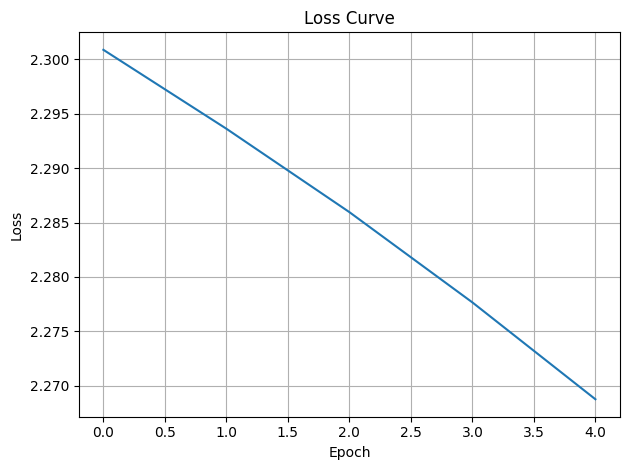

In [117]:
model = NN()
#----
for idx, layer in enumerate(model.net):
    if isinstance(layer, nn.Linear):
        layer.register_forward_hook(get_activation(f"layer_{idx}"))

#----

trainer = UltraFastTrainer(model, nn.CrossEntropyLoss(), max_epochs=5, use_amp=True)

trainer.train(train_loader)
trainer.evaluate(test_loader)
trainer.plot_loss()


In [124]:
all_epoch_activations[0]

{'layer_0': tensor([[ 0.0479,  0.1133, -0.2021,  ..., -0.3125,  0.3867,  0.1562],
         [ 0.8711,  0.7344,  0.2969,  ..., -0.3008, -1.1641,  0.4961],
         [ 0.2773,  0.4648,  0.4395,  ..., -0.5508, -0.5977,  0.0121],
         ...,
         [ 0.4922,  0.5352,  0.2656,  ..., -0.3262, -0.3574, -0.2559],
         [ 0.3984,  0.0175, -0.0713,  ..., -0.3047, -0.5977, -0.2910],
         [ 0.3008,  0.0148,  0.2197,  ...,  0.3691, -0.3633,  0.4492]],
        dtype=torch.bfloat16),
 'layer_2': tensor([[0.0000, 0.0000, 1.0391,  ..., 0.0000, 0.0000, 0.8438],
         [0.0143, 0.0000, 1.0547,  ..., 0.0000, 0.0000, 0.4609],
         [0.0000, 0.0591, 1.0078,  ..., 0.0000, 0.0000, 0.6367],
         ...,
         [0.0000, 0.0000, 0.9727,  ..., 0.0000, 0.0000, 0.7305],
         [0.0000, 0.0000, 1.0078,  ..., 0.0000, 0.0000, 0.6523],
         [0.0057, 0.0000, 1.1484,  ..., 0.0000, 0.0000, 0.8281]],
        dtype=torch.bfloat16),
 'layer_4': tensor([[-0.3438,  0.2656, -0.4805,  ..., -0.2617,  0.1338

In [119]:
activations = {}


In [120]:
def hook_fn(module, input, output):
  activations[module] = output.detach().cpu()

In [121]:
hook1 = model.net[1].register_forward_hook(hook_fn)
hook2 = model.net[3].register_forward_hook(hook_fn)
hook3 = model.net[-1].register_forward_hook(hook_fn)


In [122]:
output = model(x)

In [123]:
aa = activations[model.net[-1]]


Display.image_Display(aa[0])

ValueError: cannot reshape array of size 10 into shape (28,28)

In [ ]:
aa[0].size()

In [ ]:
image = aa[0].reshape(1,10).numpy()
plt.imshow (image, cmap = 'gray')
plt.show()

In [ ]:
aa.size()

In [ ]:
bb = activations[model.net[3]]
bb

In [ ]:
bb.size()

In [ ]:
cc = activations[model.net[5]]